In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oxml-carinoma-classification/img_701568.png
/kaggle/input/oxml-carinoma-classification/img_405863.png
/kaggle/input/oxml-carinoma-classification/img_217481.png
/kaggle/input/oxml-carinoma-classification/img_136044.png
/kaggle/input/oxml-carinoma-classification/img_585360.png
/kaggle/input/oxml-carinoma-classification/img_779156.png
/kaggle/input/oxml-carinoma-classification/img_38771.png
/kaggle/input/oxml-carinoma-classification/img_57613.png
/kaggle/input/oxml-carinoma-classification/img_279108.png
/kaggle/input/oxml-carinoma-classification/img_39157.png
/kaggle/input/oxml-carinoma-classification/img_769175.png
/kaggle/input/oxml-carinoma-classification/img_520490.png
/kaggle/input/oxml-carinoma-classification/img_630916.png
/kaggle/input/oxml-carinoma-classification/img_583497.png
/kaggle/input/oxml-carinoma-classification/img_531231.png
/kaggle/input/oxml-carinoma-classification/img_215078.png
/kaggle/input/oxml-carinoma-classification/img_49868.png
/kaggle/input/oxml

In [2]:
df=pd.read_csv('/kaggle/input/oxml-carinoma-classification/labels.csv')

df.head()

,id,malignant
0,441,-1
1,33284,-1
2,38771,1
3,46784,-1
4,57613,-1


In [3]:
df['id'] = 'img_' + df['id'].astype(str) + '.png'


df['malignant'] = df['malignant'].astype(str)

In [4]:
df.head()

,id,malignant
0,img_441.png,-1
1,img_33284.png,-1
2,img_38771.png,1
3,img_46784.png,-1
4,img_57613.png,-1


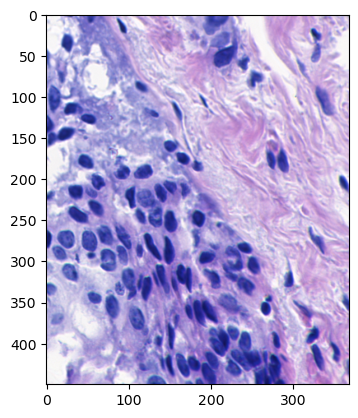

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('/kaggle/input/oxml-carinoma-classification/img_433126.png')

# Display the image
plt.imshow(img)
plt.show()

In [6]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import glob
import math
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from PIL import Image
from collections import Counter

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
labels=list(np.unique(df['malignant']))

In [8]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0.9, horizontal_flip=True, shear_range=0.2)
train_data = train_datagen.flow_from_dataframe(
    df, 
    "/kaggle/input/oxml-carinoma-classification",
    color_mode='rgb', 
    batch_size=32, 
    x_col='id', 
    y_col='malignant', 
    class_mode='categorical', 
    target_size=(300, 300)
)

Found 62 validated image filenames belonging to 3 classes.


In [9]:
base_model_1= tf.keras.applications.efficientnet.EfficientNetB2(include_top=False, weights='imagenet', input_shape=(300,300,3))

31790344/31790344 [==============================] - 0s 0us/step


In [10]:
image_batch,label_image= next(iter(train_data))
feature_batch=base_model_1(image_batch)
feature_batch.shape

TensorShape([32, 10, 10, 1408])

In [29]:
inputs=tf.keras.Input(shape=(300,300,3))
x=base_model_1(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.3)(x)
outputs=tf.keras.layers.Dense(3, activation='softmax')(x)  # updated this line
model_1=tf.keras.Model(inputs, outputs)


In [30]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, 10, 10, 1408)     7768569   
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1408)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 4227      
                                                                 
Total params: 7,772,796
Trainable params: 7,705,221
Non-trainable params: 67,575
____________________________________________

In [31]:
callback1=tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)

In [32]:
class callback2(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if (logs.get('accuracy')>0.945):
            print('\nStopping training since train accuracy is greater than 94.5%')
            self.model.stop_training=True

In [33]:
len_dataset=len(df)
batch_size=32
total_steps=round(len_dataset/batch_size)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
    maximal_learning_rate=1e-3,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * total_steps
)

In [34]:
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=clr), metrics=['accuracy'])

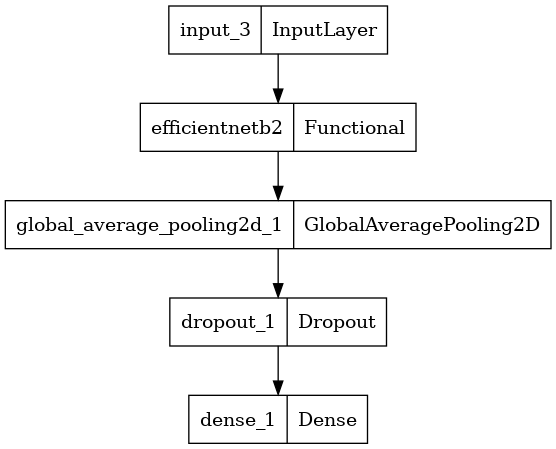

In [35]:
tf.keras.utils.plot_model(model_1)

In [36]:
history=model_1.fit(train_data, epochs=7, steps_per_epoch=total_steps, callbacks=[callback1, callback2()])


Epoch 1/7
2/2 [==============================] - 64s 12s/step - loss: 1.1265 - accuracy: 0.3710
Epoch 2/7
2/2 [==============================] - 27s 12s/step - loss: 1.1469 - accuracy: 0.3871
Epoch 3/7
2/2 [==============================] - 26s 13s/step - loss: 0.9949 - accuracy: 0.4194
Epoch 4/7
2/2 [==============================] - 27s 13s/step - loss: 0.9273 - accuracy: 0.6290
Epoch 5/7
2/2 [==============================] - 27s 12s/step - loss: 0.8322 - accuracy: 0.5968


Text(0.5, 0, 'epochs')

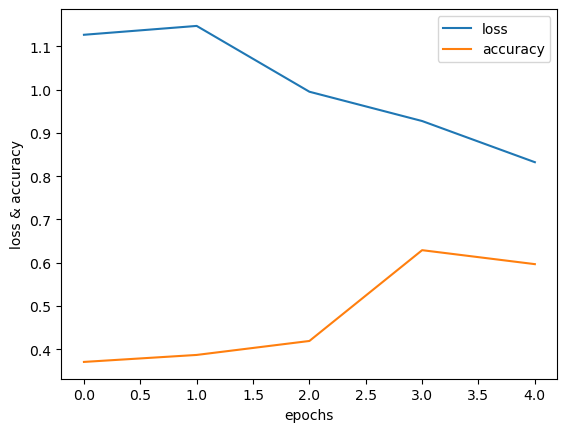

In [37]:
pd.DataFrame(history.history).plot()
plt.ylabel('loss & accuracy')
plt.xlabel('epochs')